# Homework 1 Writeup and Code
## Submitted by: Winston Pouse

In [1]:
%matplotlib inline

In [7]:
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
from scipy import io

In [ ]:
cd data/digit-dataset/


In [11]:
#import data
training_digits = io.loadmat("train.mat")
train_images_digits = training_digits['train_images']
train_images_digits = train_images_digits.reshape((28*28,-1)) #reshape so features are flattened to 1d
train_images_digits = train_images_digits.transpose() #transpose so sample number is first dimension

train_labels_digits = training_digits['train_labels']

test_digits = io.loadmat('test.mat')
test_image_digits = test_digits['test_images']
test_image_digits = test_image_digits.transpose() #test images are tranpose of training images for some reason so must tranpose first
test_image_digits = test_image_digits.reshape((28*28,-1))
test_image_digits = test_image_digits.transpose()

In [ ]:
cd ..

In [ ]:
cd spam-dataset

In [15]:
spam_data = io.loadmat('spam_data.mat')
spam_training = spam_data['training_data']
spam_training_labels = spam_data['training_labels']
spam_training_labels = spam_training_labels.transpose() #Tranpose so (number, label) shape

spam_test = spam_data['test_data']

In [16]:
import math

#benchmark.m, converted
def benchmark(pred_labels, true_labels):
    errors = pred_labels != true_labels
    err_rate = sum(errors) / float(len(true_labels))
    indices = errors.nonzero()
    return err_rate #, indices

In [17]:
def problem1(training_digits, training_digit_labels):
    #Inputs are the training digits (correctly flattened and transposed as above) and the corresponding labels
    training_numbers = [100, 200, 500, 1000, 2000, 5000,10000]
    digit_shuffled, digit_labels_shuffled = shuffle(training_digits,training_digit_labels)
    validation_digits = digit_shuffled[10000:20000, :]
    validation_digits_labels = digit_labels_shuffled[10000:20000,0]
    
    digit_prediction_list = []
    validation_errors = []
    
    for number in training_numbers:
        digits_train = digit_shuffled[0:number,:]
        digits_labels = digit_labels_shuffled[0:number, 0]
        digit_classifier = svm.LinearSVC()
        digit_classifier.fit(digits_train, digits_labels)
        
        prediction_labels = digit_classifier.predict(validation_digits)
        digit_prediction_list.append(prediction_labels)

        validation_errors.append(benchmark(prediction_labels, validation_digits_labels))
        
    plt.scatter(training_numbers, validation_errors)
    plt.xlabel('Number of Training Examples')
    plt.ylabel('Error rate')
    plt.title('Error Rate for different Digit Training Examples')
    return digit_prediction_list, validation_digits_labels
        

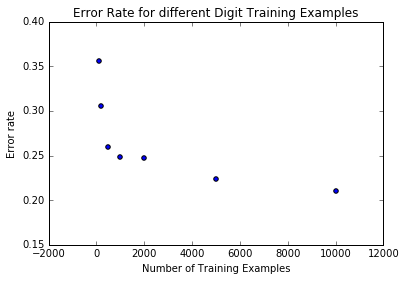

In [18]:
digit_predictions, validation_digit_labels = problem1(train_images_digits, train_labels_digits)

###### Training the linear classifier with increasing number of training examples, the error rate clearly goes down. 

In [19]:
def problem2(digit_predictions, true_labels, training_number):
    #inputs are prediction labels from problem1 and their corresponding true labels, and lastly the number of training examples
    c_matrix = confusion_matrix(true_labels, digit_predictions)
    #print(c_matrix)
    digit_strings = ['0', '1', '2', '3', '4', '5','6', '7','8','9'] #Number in string format to label tick marks
    
    def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
        #function modified from scikitlearn documentation
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title('Confusion Matrix for ' + str(training_number) + ' training examples')
        plt.colorbar()
        tick_marks = np.arange(len(range(10)))
        plt.xticks(tick_marks, digit_strings, rotation=45)
        plt.yticks(tick_marks, digit_strings)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        
    plt.figure()
    plot_confusion_matrix(c_matrix)

training_numbers = [100, 200, 500, 1000, 2000, 5000,10000]

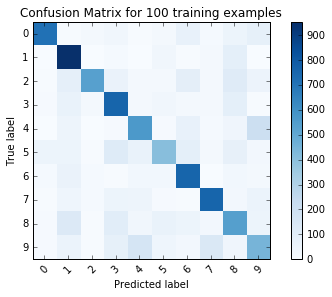

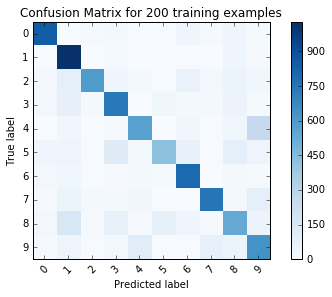

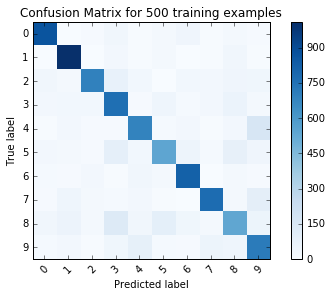

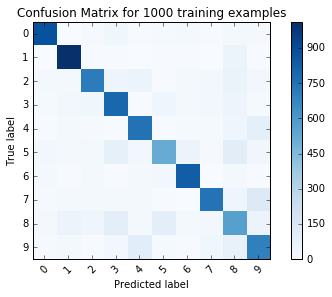

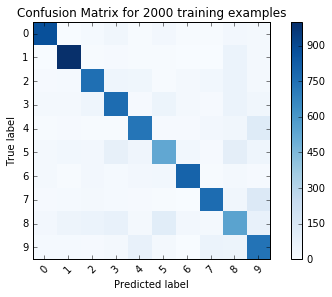

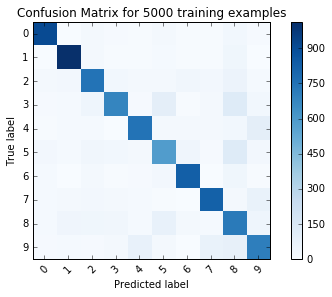

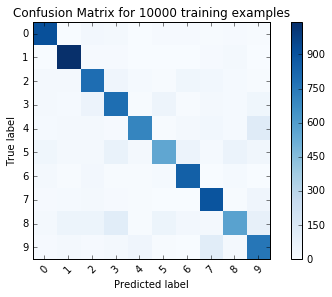

In [20]:
for i in range(len(digit_predictions)):
    problem2(digit_predictions[i], validation_digit_labels, training_numbers[i])


###### While hard to see along the diagonal, looking at the off diagonal elements we can clearly see a decrease in color indicating a decrease in incorrect prediction. Thus as expected there is a general increase in performance across the board as training examples increase. Some interesting features are that 5 and 8 seem to be the least accurate in general. Looking at the off diagonal terms we can see that it is actually due to them being classified as the other which is due to the close similarities in representation. 

In [21]:
def cross_validation(k_fold, train_images_input, train_labels_input, C_parameter=1):
    clf_cross_validation = svm.LinearSVC(C=C_parameter)
    train_images_shuffled, train_labels_shuffled = shuffle(train_images_input,train_labels_input)
    reduced_training_images = train_images_shuffled[0:10000,:]
    reduced_training_labels = train_labels_shuffled[0:10000]
    #print(reduced_training_labels)
    partition_size = len(reduced_training_labels)/k_fold
    #print(partition_size)
    validation_accuracy = 0
    for i in range(k_fold):
        validation_set = reduced_training_images[i*partition_size:((i+1)*partition_size),:]
        validation_labels = reduced_training_labels[i*partition_size:((i+1)*partition_size),0]
        #print(validation_set.shape)
        training_set = reduced_training_images[0:i*partition_size,:]
        training_set = np.append(training_set,reduced_training_images[((i+1)*partition_size):,:], axis=0)
        #print(training_set.shape)
        training_labels = reduced_training_labels[0:i*partition_size,0]
        training_labels = np.append(training_labels,reduced_training_labels[((i+1)*partition_size):,0])
        #print(len(training_set),len(training_labels))
        clf_cross_validation.fit(training_set, training_labels)
        predicted_labels = clf_cross_validation.predict(validation_set)

        err_rate=benchmark(predicted_labels, validation_labels)
        #print(err_rate)
        validation_accuracy += err_rate
    return validation_accuracy/k_fold

In [26]:
def write2csv(filename, prediction_labels):
    #Writes an array of labels to a csv file in format specified on Kaggle
    #Example:
    # Id,Category
    # 1,2
    # 2,4
    # ..
    import csv
    with open(filename, 'wb') as csvfile:
        label_writer = csv.writer(csvfile, delimiter = ',')
        label_writer.writerow(['Id','Category'])
        for i in range(len(prediction_labels)):
            label_writer.writerow([i+1,prediction_labels[i]])

In [24]:
def problem3(training_digits, training_digit_labels, test_digits):
    #inputs are fully formatted training digit images and labels as well as the testing images
    #Important that test digits are correctly formatted (need to tranpose before flattening to be same orientation as training digits)
    C_values = [1E-11, 1E-10, 1E-9,1E-8,1E-7,1E-6,1E-5,1E-4,1E-3,1E-2,1E-1,1, 10, 100, 1000]
    error_rates = []
    for C in C_values:
        error_rates.append(cross_validation(10,training_digits, training_digit_labels, C))
        
    plt.scatter(np.log10(C_values), error_rates)
    plt.xlabel('Log10(C)')
    plt.ylabel('Validation Error Rate')
    plt.title('Validation Error of Digit Classifier for Different C values')
    C_optimal = C_values[error_rates.index(min(error_rates))]
    
    
    train_images_shuffled, train_labels_shuffled = shuffle(training_digits,training_digit_labels)
    reduced_training_images = train_images_shuffled[0:10000,:]
    reduced_training_labels = train_labels_shuffled[0:10000,0]
    
    optimal_digit_clf = svm.LinearSVC(C=C_optimal)
    optimal_digit_clf.fit(reduced_training_images, reduced_training_labels)
    
    digit_predictions = optimal_digit_clf.predict(test_digits)
    print('The optimal C value is ' +str(C_optimal) + ' with a validation error rate of ' +str(min(error_rates)))
    return digit_predictions

The optimal C value is 1e-06 with a validation error rate of 0.1416


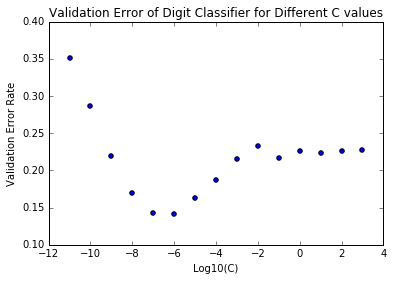

In [25]:
digit_predictions = problem3(train_images_digits, train_labels_digits, test_image_digits)
write2csv('digit_predictions.csv', digit_predictions)

###### Cross validation is useful since ideally we train on as many datasets as possible, but we still want to test our classifier. By partitioning the training data and cycling through the validation set, we maintain a large training data size, while ultimately testing on all the training data to ensure that the small validation data set is not biased in someway which affects the accuracy rate. 

###### Training an SVM with varying C values, we see from above that the optimal C value is 1E-6 with a cross validation error rate of .1416. Creating an SVM with this optimal C value and using the test data set, the Kaggle Score is an accuracy of .875 . 

In [37]:
def problem4(spam_data, spam_data_labels, testing_spam):
    #Inputs are spam data and labels provided by spam_data.mat
    C_values = [1E-11, 1E-10, 1E-9,1E-8,1E-7,1E-6,1E-5,1E-4,1E-3,1E-2,1E-1,1, 10, 100, 1000]
    spam_error_rates = []
    for C in C_values:
        spam_error_rates.append(cross_validation(6,spam_data,spam_data_labels,C))
        
    C_optimal = C_values[spam_error_rates.index(min(spam_error_rates))]
    print('The optimal C value is ' +str(C_optimal) + ' with a validation error rate of ' +str(min(spam_error_rates)))
    optimal_spam_clf = svm.LinearSVC(C=C_optimal)
    optimal_spam_clf.fit(spam_data, spam_data_labels[:,0])
    
    predicted_spam = optimal_spam_clf.predict(testing_spam)
    return predicted_spam

In [38]:
predicted_spam = problem4(spam_training, spam_training_labels, spam_test)
write2csv('spam_predictions.csv', predicted_spam)

The optimal C value is 100 with a validation error rate of 0.187161639598


###### Using cross validation for the spam dataset, the optimal C value is 100 with a validation error rate of .187 . Creating a linear SVM with this C value and using it to predict the test dataset, the resulting Kaggle score is an accuracy of .78 .